In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout

In [4]:
data_dir =r"E:\1. Thesis\PDD_MangoLeaf\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [5]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:",np.unique(df['label']))

class_counts=df['label'].value_counts()
class_counts

The classes: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

#### Modified BatchSize=32, split=60%+20%+20%, targetSize=128,128, lr=.00001

In [6]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [9]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(128,128)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(128,128))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [22]:
num_classes=8
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable=True
#inputs=base_model.input
inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs,training=False)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,909,160 (91.21 MB)

 Trainable params: 23,874,728 (91.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [24]:
epochs=10
training_history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.2040 - loss: 2.0504 - val_accuracy: 0.5238 - val_loss: 1.4229
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.5782 - loss: 1.4478 - val_accuracy: 0.7362 - val_loss: 0.9501
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.7742 - loss: 0.9971 - val_accuracy: 0.8338 - val_loss: 0.6343
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8068 - loss: 0.7556 - val_accuracy: 0.8888 - val_loss: 0.4299
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.8818 - loss: 0.5011 - val_accuracy: 0.9275 - val_loss: 0.2814
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.9108 - loss: 0.3823 - val_accuracy: 0.9513 - val_loss: 0.2046
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.9301 - loss: 0.2877 - val_accuracy: 0.9650 - val_loss: 0.1516
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9403 - loss: 0.2430 - val_accuracy: 0.9750 - v

In [25]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9799 - loss: 0.0966
Test Loss: 0.08519052714109421, Test Accuracy: 0.9775000214576721


In [26]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 664ms/step
                  precision    recall  f1-score   support

     Anthracnose       0.98      0.98      0.98       117
Bacterial Canker       1.00      0.98      0.99       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       0.98      0.95      0.96        97
      Gall Midge       0.98      0.95      0.97       107
         Healthy       0.95      1.00      0.97        77
  Powdery Mildew       0.97      0.98      0.97        98
     Sooty Mould       0.95      0.98      0.96        91

        accuracy                           0.98       800
       macro avg       0.98      0.98      0.98       800
    weighted avg       0.98      0.98      0.98       800



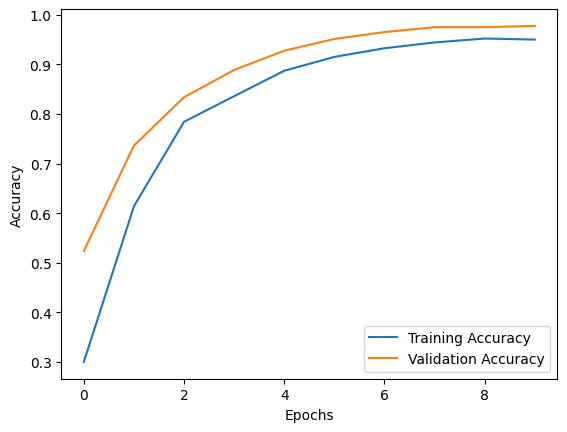

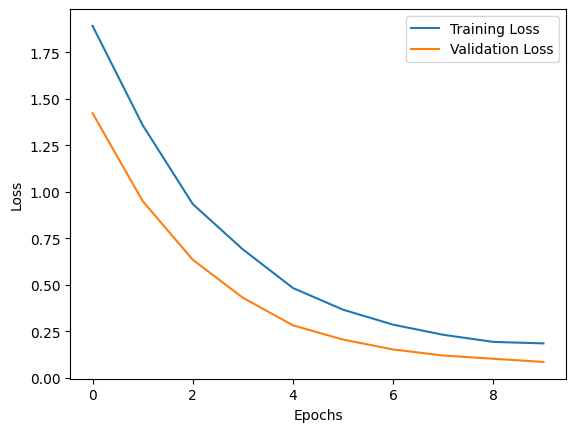

In [27]:
#plot training and validation accuracy
plt.plot(training_history.history['accuracy'],label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plot training and validation loss
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 700ms/step


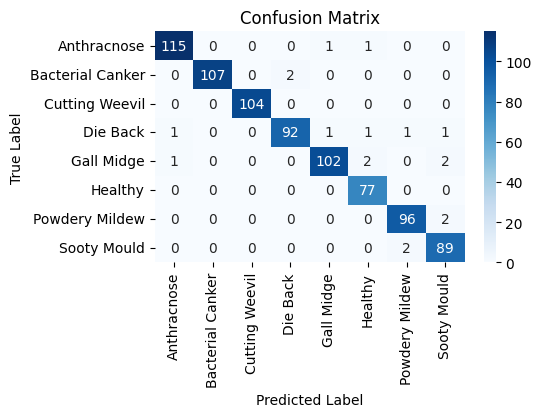

In [28]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [31]:
model.name="MangoLeaf_InceptionV3"
model.save('Inception_MangoLeaf.keras')

#### Modified BatchSize=16, split=60%+20%+20%, targetSize=128,128, lr=.001

In [44]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [49]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=16, target_size=(128,128)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=16, target_size=(128,128))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [50]:
num_classes=8
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable=True
#inputs=base_model.input
inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs,training=False)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [51]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,909,160 (91.21 MB)

 Trainable params: 23,874,728 (91.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [52]:
epochs=10
training_history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.5579 - loss: 1.4152 - val_accuracy: 0.2450 - val_loss: 591.5250
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.7778 - loss: 0.7189 - val_accuracy: 0.8637 - val_loss: 0.5090
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.8825 - loss: 0.4252 - val_accuracy: 0.8637 - val_loss: 8.0295
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.8888 - loss: 0.3801 - val_accuracy: 0.7763 - val_loss: 0.9358
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9228 - loss: 0.3055 - val_accuracy: 0.8300 - val_loss: 0.4952
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9225 - loss: 0.2468 - val_accuracy: 0.8388 - val_loss: 0.6364
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9183 - loss: 0.2784 - val_accuracy: 0.7825 - val_loss: 5.8357
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.9478 - loss: 0.1833 - val_ac

In [53]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 681ms/step - accuracy: 0.9694 - loss: 0.1218
Test Loss: 0.12195756286382675, Test Accuracy: 0.96875


In [54]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step
                  precision    recall  f1-score   support

     Anthracnose       1.00      0.97      0.98       117
Bacterial Canker       0.96      0.97      0.97       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       0.97      1.00      0.98        97
      Gall Midge       0.99      0.86      0.92       107
         Healthy       0.99      0.96      0.97        77
  Powdery Mildew       0.94      1.00      0.97        98
     Sooty Mould       0.90      1.00      0.95        91

        accuracy                           0.97       800
       macro avg       0.97      0.97      0.97       800
    weighted avg       0.97      0.97      0.97       800



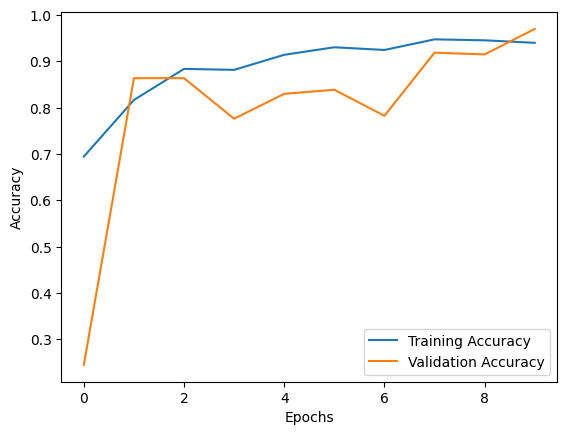

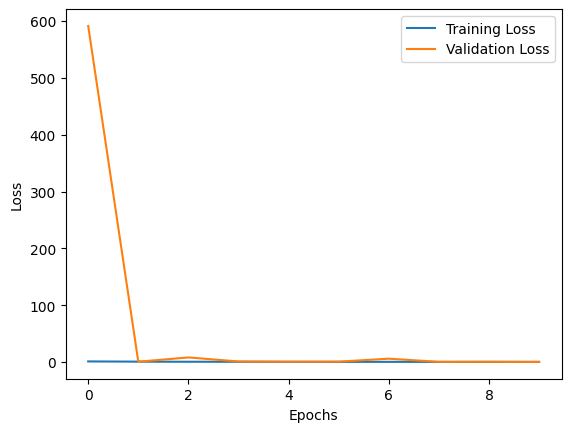

In [55]:
#plot training and validation accuracy
plt.plot(training_history.history['accuracy'],label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plot training and validation loss
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 462ms/step


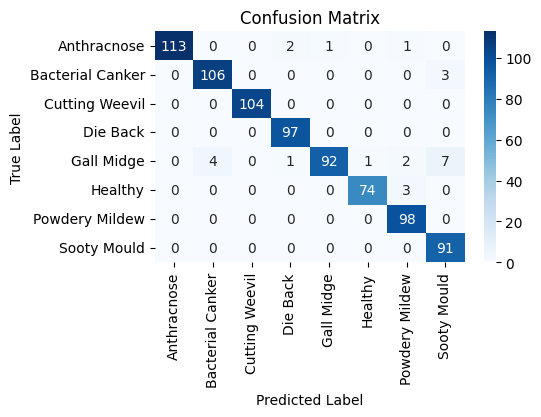

In [56]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()